# Ultimate Guide to Web Scraping with Python Part 1: Requests and BeautifulSoup

After the 2016 election I became much more interested in media bias and the manipulation of individuals through advertising. This series will be a walkthrough of a web scraping project that monitors political news from both left and right wing media outlets and performs an analysis on the rhetoric being used, the ads being displayed, and the sentiment of certain topics.

The first part of the series will we be getting media bias data and focus on only working locally on your computer, but if you wish to learn how to deploy something like this into production, feel free to leave a comment and let me know.

## Limit your impact when scraping

Every time you load a web page you're making a request to a server, and when you're just a human with a browser there's not a lot of damage you can do. With a Python script that can execute thousands of requests a second if coded incorrectly, you could end up costing the website owner a lot of money and possibly bring down their site (see [Denial-of-service attack (DoS)](https://en.wikipedia.org/wiki/Denial-of-service_attack)).

With this in mind, we want to be very careful with how we program scrapers to avoid crashing sites and causing damage. Every time we scrape a website we want to attempt to **make only one request per page**. We don't want to be making a request every time our parsing or other logic doesn't work out, so we need to parse only after we've saved the page locally.

If I'm just doing some quick tests, I'll usually start out in a Jupyter notebook because you can request a web page in one cell and have that web page available to every cell below it without making a new request. Since this article is available as a Jupyter notebook, you will see how it works if you choose that format.

### How to save HTML locally
After we make a request and retrieve a web page's content, we can store that content locally with Python's `open()` function. To do so we need to use the argument `wb`, which stands for "write bytes". This let's us avoid any encoding issues when saving.

Below is a function that wraps the `open()` function to reduce a lot of repetitive coding later on:

In [1]:
def save_html(html, path):
    with open(path, 'wb') as f:
        f.write(html)
        
        
save_html(r.content, 'google_com')

NameError: name 'r' is not defined

Assume we have captured the HTML from google.com in `html`, which you'll see later how to do. After running this function we will now have a file in the same directory as this notebook called `google_com` that contains the HTML.

### How to open/read HTML from a local file
To retrieve our saved file we'll make another function to wrap reading the HTML back into `html`. We need to use `rb` for "read bytes" in this case.

In [2]:
def open_html(path):
    with open(path, 'rb') as f:
        return f.read()
    
    
html = open_html('google_com')

FileNotFoundError: [Errno 2] No such file or directory: 'google_com'

The open function is doing just the opposite: read the HTML from `google_com`. If our script fails, notebook closes, computer shutsdown, etc., we no longer need to request google.com again, lessening our impact on their servers. While it doesn't matter much with Google since they have a lot of resources, smaller sites with smaller servers will benefit from this.

I save almost every page and parse later when web scraping as a safety precaution.

### Follow the rules for scrapers and bots
Each site usually has a **robots.txt** on the root of their domain. This is where the website owner explicitly states what bots are allowed to do on their site. Simply go to example.com/robots.txt and you should find a text file that looks something like this:

```text
User-agent: *
Crawl-delay: 10
Allow: /pages/
Disallow: /scripts/

# more stuff
```

The *User-agent* field is the name of the bot and the rules that follow are what the bot should follow. Some robots.txt will have many User-agents with different rules. Common bots are *googlebot*, *bingbot*, and *applebot*, all of which you can probably guess the purpose and origin of.

We don't really need to provide a User-agent when scraping, so `User-agent: *` is what we would follow. A `*` means that the following rules apply to *all* bots (that's us). 

The *Crawl-delay* tells us the number of seconds to wait before requests, so in this example we need to wait 10 seconds before making another request.

*Allow* gives us specific URLs we're *allowed* to request with bots, and vice versa for *Disallow*. 
In this example we're allowed to request anything in the **/pages/** subfolder which means anything that starts with **example.com/pages/**. On the other hand, we are disallowed from scraping anything from the **/scripts/** subfolder.

Many times you'll see a `*` next to Allow or Disallow which means you are either allowed or not allowed to scrape everything on the site. 

Sometimes there will be a disallow all pages followed by allowed pages like this:
```text
Disallow: *
Allow: /pages/
```
This means that you're not allowed to scrape anything *except* the subfolder */pages/*. Essentially, you just want to read the rules in order where the next rule overrides the previous rule.

## Scraping Project: Getting Media Bias Data

This project will primarily be run through a Jupyter notebook, which is done for teaching purposes and is not the usual way scrapers are programmed. After showing you the pieces, we'll put it all together into a Python script that can be run from command line or your IDE of choice.

### Making web requests
With Python's `requests` library we're getting a web page by using `get()` on the URL. The response `r` contains many things, but using `r.content` will give us the HTML. Once we have the HTML we can then parse it for the data we're interested in analyzing.

There's an interesting website called *AllSides* that has a [media bias rating table](https://www.allsides.com/media-bias/media-bias-ratings) where users can agree or disagree with the rating. 

<img src="assets/Media Bias Ratings AllSides.jpg">

Since there's nothing in their robots.txt that disallows us from scraping this section of the site, I'm assuming it's okay to go ahead and extract this data for our project. Let's request the this first page:

In [3]:
!pip install requests


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import requests

url = 'https://www.allsides.com/media-bias/media-bias-ratings'

r = requests.get(url)

print(r.content[:100])

b'<!DOCTYPE html>\n<html  lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/'


Since we essentially have a giant string of HTML, we can print a slice of 100 characters to confirm we have the source of the page. Let's start extracting data.

### Parsing HTML with BeautifulSoup
#### What does BeautifulSoup do?
We used `requests` to get the page from the AllSides server, but now we need the BeautifulSoup library to parse HTML and XML. When we pass our HTML to the BeautifulSoup constructor we get an object in return that we can then navigate like the original tree structure of the DOM. 

This way we can find elements using names of tags, classes, IDs, and through relationships to other elements, like getting the children and siblings of elements.

#### Creating a new soup object
We create a new BeautifulSoup object by passing the constructor our newly acquired HTML content and the type of parser we want to use:

In [5]:
!pip install beautifulsoup4


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(r.content, 'html.parser')

This `soup` object defines a bunch of methods — many of which can achieve the same result — that we can use to extract data from the HTML. Let's start with finding elements.

#### Finding elements and data
To find elements and data inside our HTML we'll be using `select_one`, which returns a single element, and `select`, which returns a list of elements (even if only one item exists). Both of these methods use CSS selectors to find elements, so if you're rusty on how CSS selectors work here's a quick refresher:

**A CSS selector refresher**
1. To get a tag, such as `<a></a>`, `<body></body>`, use the naked name for the tag. E.g. `select_one('a')` gets an anchor/link element, `select_one('body')` gets the body element
2. `.temp` gets an element with a class of **temp**, E.g. to get `<a class="temp"></a>` use `select_one('.temp')`
3. `#temp` gets an element with an id of **temp**, E.g. to get `<a id="temp"></a>` use `select_one('#temp')`
4. `.temp.example` gets an element with both classes **temp** and **example**, E.g. to get `<a class="temp example"></a>` use `select_one('.temp.example')`
5. `.temp a` gets an anchor element nested inside of a parent element with class **temp**, E.g. to get `<div class="temp"><a></a></div>` use `select_one('.temp a')`. Note the space between `.temp` and `a`.
6. `.temp .example` gets an element with class **example** nested inside of a parent element with class **temp**, E.g. to get `<div class="temp"><a class="example"></a></div>` use `select_one('.temp .example')`. Again, note the space between `.temp` and `.example`. The space tells the selector that the class after the space is a child of the class before the space.
7. ids, such as `<a id=one></a>`, are unique so you can usually use the id selector by itself to get the right element. No need to do nested selectors when using ids.

There's many more selectors for for doing various tasks, like selecting certain child elements, specific links, etc., that you can [look up when needed](https://www.w3schools.com/cssref/css_selectors.asp). The selectors above get us pretty close to everything we would need for now.

**Tips on figuring out how to select certain elements**

Most browsers have a quick way of finding the selector for an element using their developer tools. In Chrome, we can quickly find selectors for elements by
1. Right-click on the the element then select "Inspect" in the menu. Developer tools opens and and highlights the element we right-clicked
2. Right-click the code element in developer tools, hover over "Copy" in the menu, then click "Copy selector"

Sometimes it'll be a little off and we need to scan up a few elements to find the right one. Here's what it looks like to find the selector and Xpath, another type of selector, in Chrome:

<br />
<video src="assets/css selector vs xpath.mp4" width="700px" controls></video>

### Let's start! Getting data out of a table
Our data is housed in a table on AllSides, and by inspecting the header element we can find the code that renders the table and rows. What we need to do is `select` all the rows from the table and then parse out the information from each row.

<br />
<video src="assets/finding table in HTML.mp4" width="700px" controls></video>

Simplifying the table's HTML, the structure looks like this (comments `<!-- -->` added by me):

```html
<table>
    <thead> 
        <!-- header information --> 
    </thead>
    <tbody>
        <tr class="odd views-row-first">                                       <!-- begin table row -->
            <td class="views-field views-field-title source-title">            <!-- table cell -->
                <!-- outlet name -->
            </td> 
            <td class="views-field views-field-field-bias-image">              <!-- table cell -->
                <!-- bias data -->
            </td> 
            <td class="views-field views-field-nothing-1 what-do-you-think">   <!-- table cell -->
                <!-- agree / disagree buttons -->
            </td> 
            <td class="views-field views-field-nothing community-feedback">    <!-- table cell -->
                <!-- agree / disagree data -->
            </td> 
        </tr>                                                                  <!-- end table row -->
        <!-- more rows -->
    </tbody>
</table>
```

So to get each row, we just select all `<tr>` inside `<tbody>`:

In [11]:
rows = soup.select('tbody tr')

In [15]:
print(soup)

<!DOCTYPE html>

<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">
<head profile="http://www.w3.org/1999/xhtml/vocab">
<meta charset="utf-8"/>
<link href="https://www.allsides.com/sites/default/files/AllSides-Icon.png" rel="shortcut icon" type="image/png"/>
<meta content="555035668344688" property="fb:app_id"/>
<meta content="Everyone is biased — and that's okay. Unbiased news doesn't exist. But hidden media bias misleads, manipulates and divides us. AllSides Media Bias Ratings™ make media bias transparent, helping you to easily identify different perspectives so you can get the full picture and think for yourself." name="description"/>
<link href="https://www.allsides.com/media-bias" rel="canonical"

In [18]:
print(rows[0])

<tr class="odd views-row-first">
<td class="views-field views-field-title">
<a href="/news-source/associated-press-media-bias">Associated Press</a> </td>
<td class="views-field views-field-field-bias-image">
<a href="/media-bias/left-center"><img alt="AllSides Media Bias Rating: Lean Left" height="20" src="https://www.allsides.com/sites/default/files/styles/bias120x20/public/bias-leaning-left.png?itok=yY9UMoH-" title="AllSides Media Bias Rating: Lean Left" typeof="foaf:Image" width="120"/></a> </td>
<td class="views-field views-field-nothing-1 what-do-you-think">
<div class="agree-disagree-widget"><div class="rate-widget-4 rate-widget clear-block rate-average rate-widget-yesno rate-c1839f412d43f34ad588d9ac367a9b99 rate-node-3515-4-1" id="rate-node-3515-4-1">
<div class="item-list"><ul><li class="first"><a class="rate-button rate-btn" href="/media-bias?nbsp=&amp;rate=-SGBqO8D5hZUwgHbyb16LBBpOR-4JO5INn78Tu4Od0g" id="rate-button-3" rel="nofollow" title="agree">agree</a></li>
<li class="la

`tbody tr` tells the selector to extract all `<tr>` (**t**able **r**ow) tags that are children of the `<tbody>` body tag. If there were more than one table on this page we would have to make a more specific selector, but since this is the only table, we're good to go.

Now we have a list of HTML table rows that each contain four cells: 
- News source name and link
- Bias data
- Agreement buttons
- Community feedback data

Below is a breakdown of how to extract each one.

#### News source name
<br />
<video src="assets/news source name.mp4" width="700px" controls></video>

Let's look at the first cell:
```html
<td class="views-field views-field-title source-title">
    <a href="/news-source/abc-news-media-bias">ABC News</a>
</td>
```

The outlet name (*ABC News*) is the text of an anchor tag that's nested inside a `<td>` tag, which is a cell — or **t**able **d**ata tag.


Getting the outlet name is pretty easy: just get the first row in `rows` and run a `select_one` off that object:

In [19]:
row = rows[0]

#name = row.select_one('.source-title').text.strip()
name = row.select_one('.views-field-title').text.strip()

print(name)

Associated Press


The only class we needed to use in this case was `.source-title` since `.views-field` looks to be just a class each row is given for styling and doesn't provide any uniqueness.

Notice that we didn't need to worry about selecting the anchor tag `a` that contains the text. When we use `.text` is gets all text in that element, and since "ABC News" is the only text, that's all we need to do. Bear in mind that using `select` or `select_one` will give you the whole element with the tags included, so we need `.text` to give us the text between the tags.

`.strip()` ensures all the whitespace surrounding the name is removed. This is a good thing to always do since many websites use whitespace as a way to visually pad the text inside elements.

You'll notice that we can run BeautifulSoup methods right off one of the rows. That's because the rows become their own BeautifulSoup objects when we make a select from another BeautifulSoup object. On the other hand, our `name` variable is no longer a BeautifulSoup object because we called `.text`.

### News source page link
We also need the link to this news source's page on AllSides. If we look back at the HTML we'll see that in this case we *do* want to select the anchor in order to get the `href` that contains the link, so let's do that:

In [20]:
#allsides_page = row.select_one('.source-title a')['href']
allsides_page = row.select_one('.views-field-title a')['href']
allsides_page = 'https://www.allsides.com' + allsides_page

print(allsides_page)

https://www.allsides.com/news-source/associated-press-media-bias


It is a relative path in the HTML, so we prepend the site's URL to make it a link we can request later. 

Getting the link was a bit different than just selecting an element. We had to access an *attribute* (`href`) of the element, which is done using brackets, like how we would access a Python dictionary. This will be the same for other attributes of elements, like `src` in images and videos.

### Bias rating

<br />
<video src="assets/bias rating.mp4" width="700px" controls></video>

We can see that the rating is displayed as an image so how can we get the rating in words? Looking at the HTML notice the link that surrounds the image has the text we need:

```html
<td class="views-field views-field-field-bias-image">
    <a href="/media-bias/left-center">
        <img src="..." width="144" height="24" alt="Political News Media Bias Rating: Lean Left" title="Political News Media Bias Rating: Lean Left">
    </a>          
</td>
```

We could also pull the `alt` attribute, but the link looks easier. Let's grab it:

In [21]:
bias = row.select_one('.views-field-field-bias-image a')['href']
bias = bias.split('/')[-1]

print(bias)

left-center


Here we selected the anchor tag by using the class name and tag together: `.views-field-field-bias-image` is the class of the `<td>` and `<a>` is for the anchor nested inside. 

After that we extract the `href` just like before, but now we only want the last part of the URL for the name of the bias so we split on slashes and get the last element of that split (*left-center*).

### Community feedback data

<br />
<video src="assets/agree ratio community feedback.mp4" width="700px" controls></video>

The last thing to scrape is the agree/disagree ratio from the community feedback area. The HTML of this cell is pretty convoluted due to the styling, but here's the basic structure:

```html
<td class="views-field views-field-nothing community-feedback">
    <div class="getratingval">
        <div class="rate-widget-4 rate-widget clear-block rate-average rate-widget-yesno" id="rate-node-76-4-1">
             <div class="item-list">
                <ul>
                    <li class="first">
                        <a class="rate-button rate-btn" href="..." id="rate-button-3">agree</a>
                    </li>
                    <li class="last">
                        <a class="rate-button rate-btn" href="..." id="rate-button-4">disagree</a>
                    </li>
                </ul>
            </div>
            <div class="rate-details">
                <span class="agree">8241</span>/<span class="disagree">6568</span>
            </div>
        </div>
    </div>
</td>
```

The numbers we want are located in two `span` elements in the last `div`. Both `span` elements have classes that are unique in this cell so we can use them to make the selection:

In [22]:
agree = row.select_one('.agree').text
agree = int(agree)

disagree = row.select_one('.disagree').text
disagree = int(disagree)

agree_ratio = agree / disagree

print(f"Agree: {agree}, Disagree: {disagree}, Ratio {agree_ratio:.2f}")

Agree: 33277, Disagree: 26084, Ratio 1.28


Using `.text` will return a string, so we need to convert them to integers in order to calculate the ratio. 

**Side note:** If you've never seen this way of formatting print statements in Python, the `f` at the front allows us to insert variables right into the string using curly braces. The `:.2f` is a way to format floats to only show two decimals places.

If you look at the page in your browser you'll notice that they say how much the community is in agreement by using "somewhat agree", "strongly agree", etc. so how do we get that? If we try to select it:

In [23]:
print(row.select_one('.community-feedback-rating-page'))

None


It shows up as None because this element is rendered with Javascript and `requests` can't pull HTML rendered with Javascript. We'll be looking at how to get data rendered with JS in a later article, but since this is the only piece of information that's rendered this way we can manually recreate the text.

To find the JS files they're using, just CTRL+F for ".js" in the page source and open the files in a new tab to look for that logic. 

It turned out the logic was located in the eleventh JS file and they have a function that calculates the text and color with these parameters:

<table width="300px">
    <thead>
        <td>Range</td>
        <td>Agreeance</td>
    </thead>
    <tr>
        <td>$ratio > 3$</td>
        <td>absolutely agrees</td>
    </tr>
    <tr>
        <td>$2 < ratio \leq 3$</td>
        <td>strongly agrees</td>
    </tr>
    <tr>
        <td>$1.5 < ratio \leq 2$</td>
        <td>agrees</td>
    </tr>
    <tr>
        <td>$1 < ratio \leq 1.5$</td>
        <td>somewhat agrees</td>
    </tr>
    <tr>
        <td>$ratio = 1$</td>
        <td>neutral</td>
    </tr>
    <tr>
        <td>$0.67 < ratio < 1$</td>
        <td>somewhat disgrees</td>
    </tr>
    <tr>
        <td>$0.5 < ratio \leq 0.67$</td>
        <td>disgrees</td>
    </tr>
    <tr>
        <td>$0.33 < ratio \leq 0.5$</td>
        <td>strongly disagrees</td>
    </tr>
    <tr>
        <td>$ratio \leq 0.33$</td>
        <td>absolutely disagrees</td>
    </tr>
</table>

Let's make a function that replicates this logic:

In [24]:
def get_agreeance_text(ratio):
    if ratio > 3: return "absolutely agrees"
    elif 2 < ratio <= 3: return "strongly agrees"
    elif 1.5 < ratio <= 2: return "agrees"
    elif 1 < ratio <= 1.5: return "somewhat agrees"
    elif ratio == 1: return "neutral"
    elif 0.67 < ratio < 1: return "somewhat disagrees"
    elif 0.5 < ratio <= 0.67: return "disagrees"
    elif 0.33 < ratio <= 0.5: return "strongly disagrees"
    elif ratio <= 0.33: return "absolutely disagrees"
    else: return None
    
print(get_agreeance_text(2.5))

strongly agrees


Now that we have the general logic for a single row and we can generate the agreeance text, let's create a loop that gets data from every row on the first page:

In [26]:
data= []

for row in rows:
    d = dict()
    
    #d['name'] = row.select_one('.source-title').text.strip()
    d['name'] = row.select_one('.views-field-title').text.strip()
    d['allsides_page'] = 'https://www.allsides.com' + row.select_one('.views-field-title a')['href']
    d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
    d['agree'] = int(row.select_one('.agree').text)
    d['disagree'] = int(row.select_one('.disagree').text)
    d['agree_ratio'] = d['agree'] / d['disagree']
    d['agreeance_text'] = get_agreeance_text(d['agree_ratio'])
    
    data.append(d)   

In the loop we can combine any multi-step extractions into one to create the values in the least number of steps.

Our `data` list now contains a dictionary containing key information for every row. 

In [27]:
print(data[0])

{'name': 'Associated Press', 'allsides_page': 'https://www.allsides.com/news-source/associated-press-media-bias', 'bias': 'left-center', 'agree': 33277, 'disagree': 26084, 'agree_ratio': 1.275762919797577, 'agreeance_text': 'somewhat agrees'}


Keep in mind that **this is still only the first page**. The list on *AllSides* is three pages long as of this writing, so we need to modify this loop to get the other pages.

### Requesting and parsing multiple pages

Notice that the URLs for each page follow a pattern. The first page has no parameters on the URL, but the next pages do; specifically they attach a `?page=#` to the URL where '#' is the page number. 

Right now, the easiest way to get all pages is just to manually make a list of these three pages and loop over them. If we were working on a project with thousands of pages we might build a more automated way of constructing/finding the next URLs, but for now this works.

In [28]:
pages = [
    'https://www.allsides.com/media-bias/media-bias-ratings',
    'https://www.allsides.com/media-bias/media-bias-ratings?page=1',
    'https://www.allsides.com/media-bias/media-bias-ratings?page=2'
]

According to AllSides' *robots.txt* we need to make sure we wait ten seconds before each request. 

Our loop will:
- request a page
- parse the page
- wait ten seconds
- repeat for next page.

Remember, we've already tested our parsing above on a page that was cached locally so we know it works. You'll want to make sure to do this **before** making a loop that performs requests to prevent having to reloop if you forgot to parse something.

By combining all the steps we've done up to this point and adding a loop over pages, here's how it looks:

In [29]:
from time import sleep

data= []

for page in pages:
    r = requests.get(page)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    rows = soup.select('tbody tr')

    for row in rows:
        d = dict()

        d['name'] = row.select_one('.views-field-title').text.strip()
        d['allsides_page'] = 'https://www.allsides.com' + row.select_one('.views-field-title a')['href']
        d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
        d['agree'] = int(row.select_one('.agree').text)
        d['disagree'] = int(row.select_one('.disagree').text)
        d['agree_ratio'] = d['agree'] / d['disagree']
        d['agreeance_text'] = get_agreeance_text(d['agree_ratio'])

        data.append(d)
    
    sleep(10)

Now we have a list of dictionaries for each row on all three pages. 

To cap it off, we want to get the real URL to the news source, not just the link to their presence on AllSides. To do this, we will need to get the AllSides page and look for the link.

If we go to [ABC News' page](https://www.allsides.com/news-source/abc-news-media-bias) there's a row of external links to Facebook, Twitter, Wikipedia, and the ABC News website. The HTML for that sections looks like this:

```html
<div class="row-fluid source-links gray-bg-box">
	<div class="container">	
		<a href="https://www.facebook.com/ABCNews/" class="facebook">
            <i class="fa fa-facebook" aria-hidden="true"></i><span>Facebook</span>
        </a>
		<a href="https://twitter.com/ABC" class="twitter">
            <i class="fa fa-twitter" aria-hidden="true"></i>
            <span>Twitter</span>
        </a>
		<a href="https://en.wikipedia.org/wiki/ABC_News" class="wikipedia">
            <i class="fa fa-wikipedia-w" aria-hidden="true"></i>
            <span>Wikipedia</span>
        </a>
		<a href="http://abcnews.go.com/" class="www"><i class="fa fa-globe" aria-hidden="true">
            </i><span>ABC News</span>
        </a>
		<a href="/contact" class="improve-this-page">
            <i class="fa fa-line-chart" aria-hidden="true"></i>
            <span>Improve this page</span>
        </a>
	</div>
</div>
```
Notice the anchor tag (`<a>`) that contains the link to ABC News has a class of "www". Pretty easy to get with what we've already learned:

In [30]:
website = soup.select_one('.www')['href']

TypeError: 'NoneType' object is not subscriptable

In [31]:
print(soup)

<!DOCTYPE html>

<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">
<head profile="http://www.w3.org/1999/xhtml/vocab">
<meta charset="utf-8"/>
<link href="https://www.allsides.com/sites/default/files/AllSides-Icon.png" rel="shortcut icon" type="image/png"/>
<meta content="555035668344688" property="fb:app_id"/>
<meta content="Everyone is biased — and that's okay. Unbiased news doesn't exist. But hidden media bias misleads, manipulates and divides us. AllSides Media Bias Ratings™ make media bias transparent, helping you to easily identify different perspectives so you can get the full picture and think for yourself." name="description"/>
<link href="https://www.allsides.com/media-bias" rel="canonical"

So let's make another loop to request the AllSides page and get links for each news source. Unfortunately, some pages don't have a link in this grey bar to the news source, which brings up a good point: **always account for elements to randomly not exist**.

Up until now we've assumed elements exist in the tables we scraped, but it's always a good idea to program scrapers in way so they don't break when an element goes missing.

Using `select_one` or `select` will always return None or an empty list if nothing is found, so in this loop we'll check if we found the website element or not so it doesn't throw an Exception when trying to access the `href` attribute.

Finally, since there's 265 news source pages and the wait time between pages is 10 seconds, it's going to take ~44 minutes to do this. Instead of blindly not knowing our progress, let's use the `tqdm` library to give us a nice progress bar:

In [32]:
!pip install tqdm


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from tqdm import tqdm_notebook

for d in tqdm_notebook(data):
    r = requests.get(d['allsides_page'])
    soup = BeautifulSoup(r.content, 'html.parser')
    
    try:
        website = soup.select_one('.www')['href']
        d['website'] = website
    except TypeError:
        pass
    
    sleep(10)

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_12536\2804548961.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(data):


  0%|          | 0/57 [00:00<?, ?it/s]

`tqdm` is a little weird at first, but essentially `tqdm_notebook` is just wrapping around our data list to produce a progress bar. We are still able to access each dictionary, `d`, just as we would normally. Note that `tqdm_notebook` is only for Jupyter notebooks. In regular editors you'll just `import tqdm from tqdm` and use `tqdm` instead.

### Saving our data
So what do we have now? At this moment, `data` is a list of dictionaries, each of which contains all the data from the tables as well as the websites from each individual news source's page on AllSides.

The first thing we'll want to do now is save that data to a file so we don't have to make those requests again. We'll be storing the data as JSON since it's already in that form anyway:

In [34]:
import json

with open('allsides.json', 'w') as f:
    json.dump(data, f)

To load it back in when you need it:

In [35]:
with open('allsides.json', 'r') as f:
    data = json.load(f)

If you're not familiar with JSON, just quickly open `allsides.json` in an editor and see what it looks like. It should look almost exactly like what `data` looks like if we print it in Python: a list of dictionaries.

## Brief Data Analysis

Before ending this article I think it would be worthwhile to actually see what's interesting about this data we just retrieved. So, let's answer a couple of questions.

**Which ratings for outlets does the community *absolutely agree* on?**

To find where the community absolutely agrees we can do a simple list comprehension that checks each `dict` for the agreeance text we want:

In [36]:
abs_agree = [d for d in data if d['agreeance_text'] == 'absolutely agrees']

print(f"{'Outlet':<20} {'Bias':<20}")
print("-" * 30)

for d in abs_agree:
    print(f"{d['name']:<20} {d['bias']:<20}")

Outlet               Bias                
------------------------------
New York Times (Opinion) left                
New York Times (Opinion) left                
New York Times (Opinion) left                


Using some string formatting we can make it look somewhat tabular. Interestingly, *C-SPAN* is the only center bias that the community absolutely agrees on. The others for left and right aren't that surprising.

### Making analysis easier with Pandas

**Which ratings for outlets does the community *absolutely disagree* on?**

To make analysis a little easier, we can also load our JSON data into a Pandas DataFrame as well. This is easy with Pandas since they have a simple function for reading JSON into a DataFrame.

As an aside, if you've never used Pandas, Matplotlib, or any of the other data science libraries, I would definitely recommend checking out [Jose Portilla's data science course]() for a great intro to these tools and many machine learning concepts.

Now to the DataFrame:

In [37]:
import pandas as pd

df = pd.read_json(open('allsides.json', 'r'))

df.set_index('name', inplace=True)

df.head()

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text
name,,,,,,
Associated Press,https://www.allsides.com/news-source/associate...,left-center,33277,26084,1.275763,somewhat agrees
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61231,51735,1.183551,somewhat agrees
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52138,52710,0.989148,somewhat disagrees
Insider,https://www.allsides.com/news-source/insider-m...,left-center,4816,7075,0.680707,somewhat disagrees
National Review,https://www.allsides.com/news-source/national-...,right,22112,9197,2.404262,strongly agrees


Now filter the DataFrame by "agreeance_text":

In [38]:
df[df['agreeance_text'] == 'strongly disagrees']

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text
name,,,,,,


It looks like much of the community disagrees strongly with certain outlets being rated with a "center" bias.

Let's make a quick visualization of agreeance. Since there's too many news sources to plot so let's pull only those with the most votes. To do that, we can make a new column that counts the total votes and then sort by that value:

In [39]:
df['total_votes'] = df['agree'] + df['disagree']
df.sort_values('total_votes', ascending=False, inplace=True)

df.head(10)

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text,total_votes
name,,,,,,,
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61252,51738,1.183888,somewhat agrees,112990
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61252,51738,1.183888,somewhat agrees,112990
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61231,51735,1.183551,somewhat agrees,112966
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52158,52722,0.989302,somewhat disagrees,104880
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52158,52722,0.989302,somewhat disagrees,104880
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52138,52710,0.989148,somewhat disagrees,104848
New York Times (News),https://www.allsides.com/news-source/new-york-...,left-center,33470,43276,0.773408,somewhat disagrees,76746
New York Times (News),https://www.allsides.com/news-source/new-york-...,left-center,33470,43276,0.773408,somewhat disagrees,76746
New York Times (News),https://www.allsides.com/news-source/new-york-...,left-center,33463,43270,0.773353,somewhat disagrees,76733


#### Visualizing the data

To make a bar plot we'll use Matplotlib with Seaborn's dark grid style:

In [40]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

As mentioned above, we have too many news outlets to plot comfortably, so just make a copy of the top 25 and place it in a new `df2` variable:

In [41]:
df2 = df.head(25).copy()

df2.head()

,allsides_page,bias,agree,disagree,agree_ratio,agreeance_text,total_votes
name,,,,,,,
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61252,51738,1.183888,somewhat agrees,112990
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61252,51738,1.183888,somewhat agrees,112990
CNN (Online News),https://www.allsides.com/news-source/cnn-media...,left,61231,51735,1.183551,somewhat agrees,112966
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52158,52722,0.989302,somewhat disagrees,104880
Fox News (Online News),https://www.allsides.com/news-source/fox-news-...,right,52158,52722,0.989302,somewhat disagrees,104880


With the top 25 news sources by amount of feedback, let's create a stacked bar chart where the number of *agrees* are stacked on top of the number of *disagrees*. This makes the total height of the bar the total amount of feedback.

Below, we first create a figure and axes, plot the agree bars, plot the disagree bars on top of the agrees using `bottom`, then set various text features:

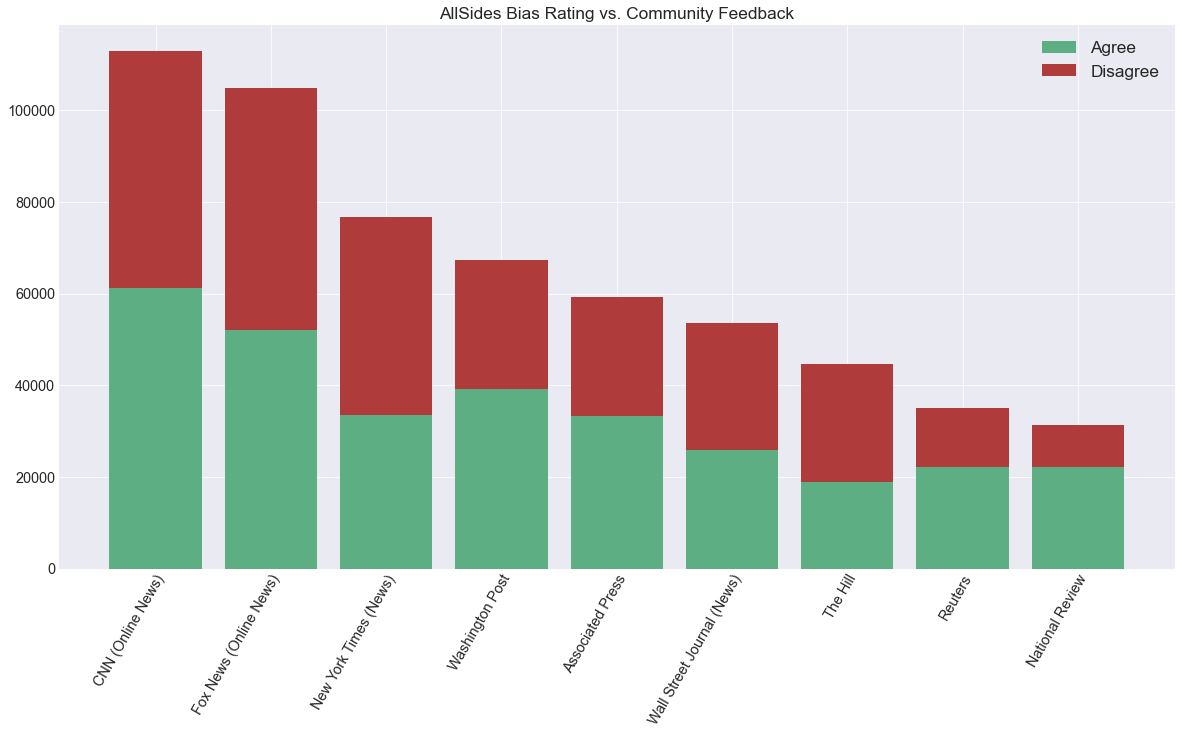

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(df2.index, df2['agree'], color='#5DAF83')
ax.bar(df2.index, df2['disagree'], bottom=df2['agree'], color='#AF3B3B')

ax.set_ylabel = 'Total feedback'

plt.yticks(fontsize='x-large')
plt.xticks(rotation=60, ha='right', fontsize='x-large', rotation_mode='anchor')

plt.legend(['Agree', 'Disagree'], fontsize='xx-large')
plt.title('AllSides Bias Rating vs. Community Feedback', fontsize='xx-large')
plt.show()

For a slightly more complex version, let's make a subplot for each bias and plot the respective news sources.

This time we'll make a new copy of the original DataFrame beforehand since we can plot more news outlets now.

Instead of making one axes, we'll create a new one for each bias to make six total subplots:

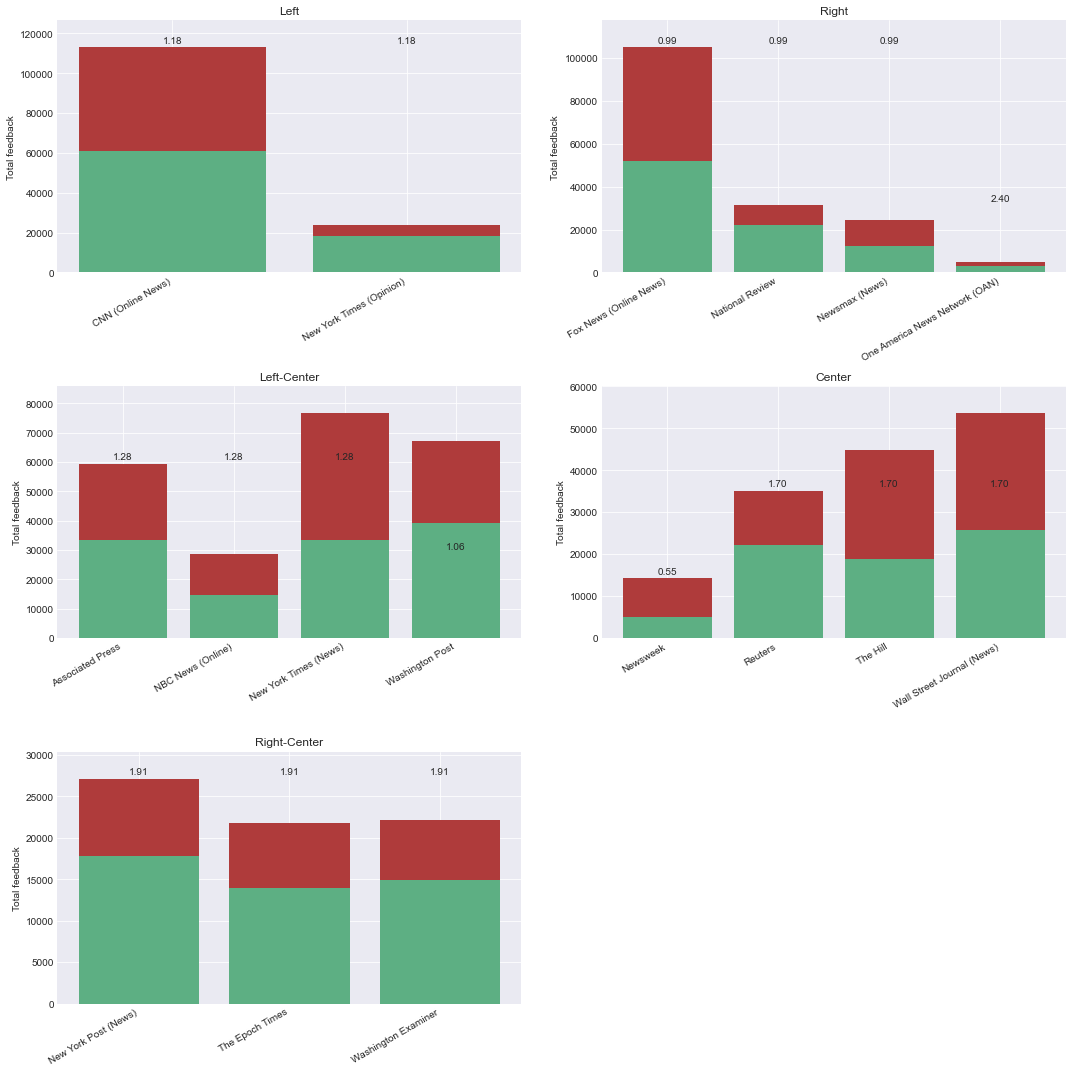

In [64]:
import math
df3 = df.copy()

fig = plt.figure(figsize=(15,15))

biases = df3['bias'].unique()

for i, bias in enumerate(biases):
    # Get top 10 news sources for this bias and sort index alphabetically
    temp_df = df3[df3['bias'] == bias].iloc[:10]
    temp_df.sort_index(inplace=True)
    
    # Get max votes, i.e. the y value for tallest bar in this temp dataframe
    max_votes = temp_df['total_votes'].max()
    
    # Add a new subplot in the correct grid position
    ax = fig.add_subplot(math.ceil(len(biases) / 2), 2, i + 1)
    
    # Create the stacked bars
    ax.bar(temp_df.index, temp_df['agree'], color='#5DAF83')
    ax.bar(temp_df.index, temp_df['disagree'], bottom=temp_df['agree'], color='#AF3B3B')
    
    # Place text for the ratio on top of each bar
    for x, y, ratio in zip(ax.get_xticks(), temp_df['total_votes'], temp_df['agree_ratio']):
        ax.text(x, y + (0.02 * max_votes), f"{ratio:.2f}", ha='center')
    
    ax.set_ylabel('Total feedback')
    ax.set_title(bias.title())
    
    # Make y limit larger to compensate for text on bars
    ax.set_ylim(0, max_votes + (0.12 * max_votes))
    
    # Rotate tick labels so they don't overlap
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout(w_pad=3.0, h_pad=1.0)
plt.show()

In [63]:
import math
for i, bias in enumerate(biases):
    print(i, bias)
print(math.ceil(len(biases)/2))

0 left
1 right
2 left-center
3 center
4 right-center
3


Hopefully the comments help with how these plots were created. We're just looping through each unique bias and adding a subplot to the figure.

When interpreting these plots keep in mind that the y-axis has different scales for each subplot. Overall it's a nice way to see which outlets have a lot of votes and where the most disagreement is. This is what makes scraping so much fun!

## Final words

We have the tools to make some fairly complex web scrapers now, but there's still the issue with Javascript rendering. This is something that deserves its own article, but for now we can do quite a lot.

There's also some project organization that needs to occur when making this into a more easily runnable program. We need to pull it out of this notebook and code in command-line arguments if we plan to run it often for updates.

These sorts of things will be addressed later when we build more complex scrapers, but feel free to let me know in the comments of anything in particular you're interested in learning about.